For this Project i used Ham/Spam Dataset a open Dataset from Nitisha in Kaggle
https://www.kaggle.com/nitishabharathi/email-spam-dataset
It is a compilation of 3 Datasets for spam email filtering. But we will focuse one

* completeSpamAssassin

Label 1 for Spam and 0 for Ham


# Spam and Ham Classification with Pytorch and LSTM

<font color='cyan'>**Presentation**</font> 

In this Notebook we will try to make a classification of ham and spam
* Spam : unwanted email , usually advertissements
* Ham : good mail

<font color='cyan'>**Import and explore**</font> 

In this first step we will import the data shape and see the features
also take a over look in the data to see how to clean it

<font color='pink'>**Import**</font> 

First import and global Overview

In [53]:
import os

import pandas as pd

raw = pd.read_csv("completeSpamAssassin.csv", encoding="utf-8")
raw.shape, raw.keys()

((6046, 3), Index(['Unnamed: 0', 'Body', 'Label'], dtype='object'))

<font color='pink'>**Explore**</font> 

let's see the repartition of datas:
* Plot the number of occurence by label
* Plot a Wordcloud
* Plot the top 10 of words by their frequency
* Take a look to the top 200 Words to see if there is word that we can avoid for the analyse

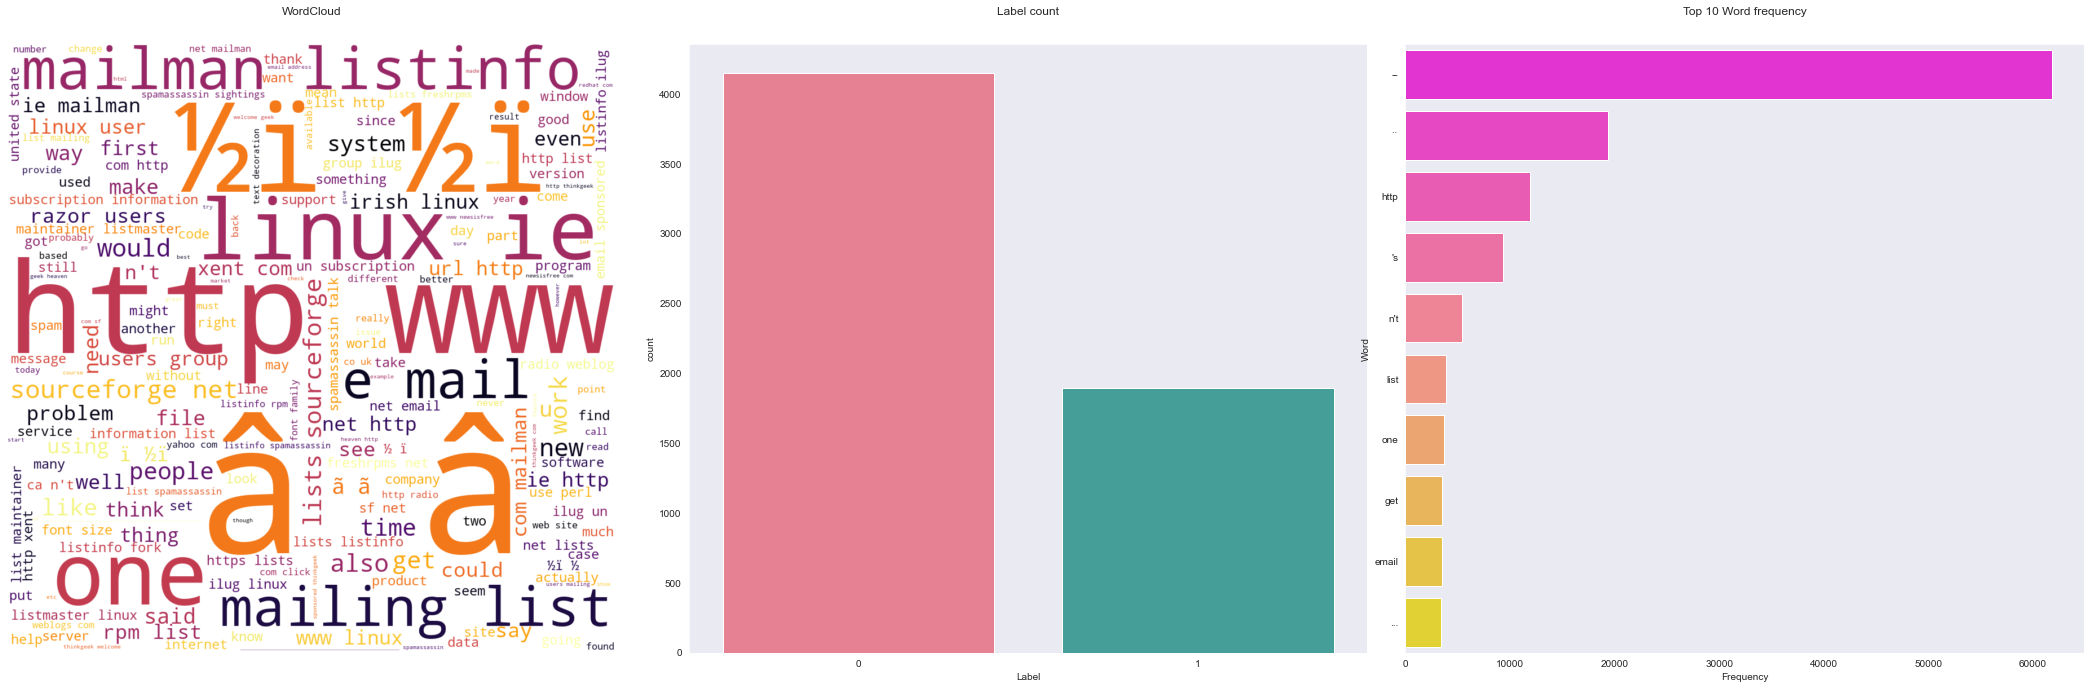

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud

sns.set_style("dark")

stop_words = set(stopwords.words("english"))
to_word = lambda text: [
    i.lower() for i in word_tokenize(str(text)) if i.lower() not in stop_words
]

raw["words"] = raw["Body"].apply(to_word)

text = " ".join(" ".join(w) for w in raw["words"])

plt.rcParams["figure.figsize"] = (30, 9)


fig, axes = plt.subplots(1, 3)
fig.tight_layout(pad=1.0)

wcld = WordCloud(
    background_color="white",
    width=1080,
    height=1080,
    colormap="inferno",
    contour_width=3,
    stopwords=stop_words,
).generate(text)

# Plot worldcloud
axes[0].imshow(wcld, interpolation="bilinear")
axes[0].title.set_text("WordCloud\n\n")
axes[0].axis("off")

# Plot count_label
sns.countplot(x=raw["Label"], palette="husl", ax=axes[1])
axes[1].title.set_text("Label count\n\n")

# Plot frequence
word_tokens = word_tokenize(text)
tokens = list()
for word in word_tokens:
    if word not in stop_words and len(word) != 1:
        tokens.append(word)

token_dist = FreqDist(tokens)
dist = pd.DataFrame(token_dist.most_common(10), columns=["Word", "Frequency"])

sns.barplot(x="Frequency", y="Word", data=dist, palette="spring", ax=axes[2])
axes[2].title.set_text("Top 10 Word frequency\n\n")
plt.show()

let's see if there is reccurents words that could disturb the classification 

In [49]:
", ".join([i[0] for i in token_dist.most_common(200)])

"--, ``, http, 's, n't, list, one, get, email, ..., free, new, would, people, like, time, 2002, use, information, make, click, mailing, please, also, us, business, money, wrote, message, linux, work, 'm, could, may, address, know, even, see, linux.ie, want, web, 've, way, send, internet, need, first, much, e-mail, software, world, using, group, said, many, home, system, 'll, think, mail, find, 're, users, good, name, order, spam, help, well, file, date, take, go, company, years, subject, _______________________________________________, https, government, right, report, url, back, still, best, site, program, every, subscription, today, check, receive, used, two, windows, without, day, service, read, line, number, phone, since, change, made, really, say, something, irish, available, server, security, set, computer, color, link, news, online, un, last, code, sure, problem, 'd, better, million, files, never, ca, ilug, life, credit, another, sent, next, data, look, maintainer, year, offer, 

<font color='cyan'>**Data Cleaning**</font> 

Let's add a feature length to see if the leght has an impact to the type of mail
Purpose : if there is a coleanarity between the lenght and spamost data are Spams

* Drop empty body
* Clean the datas by removing unnecessery charachter like "\n" and some not relevant word like "www"


In [21]:
df = raw[["Body", "Label"]]
df = df.dropna()
df = df[df["Body"] != "empty"].dropna()
df["Body"] = df["Body"].astype(str)
df.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [22]:
import re

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords


def clean_mail(mail):
    mail = re.sub(r"text-(\w+)", " ", mail, flags=re.IGNORECASE)
    mail = re.sub(r"font-(\w+)", " ", mail, flags=re.IGNORECASE)
    # remove \n and \t
    mail = re.sub(r"[\n|\t]", " ", mail)
    # Remove special characters and digits
    mail = re.sub(r"[^a-zA-Z]", " ", mail)
    # remove links
    mail = re.sub("www", " ", re.sub("http", " ", mail, flags=re.IGNORECASE))
    # e mail to - e-mail
    mail = re.sub(r"e mail", "e-mail", mail)

    return mail


df["Body"] = df["Body"].apply(clean_mail)
df.dropna(inplace=True)
df.head()

,Body,Label
0,Save up to on Life Insurance Why Spend M...,1
1,Fight The Risk of Cancer adclick ws ...,1
2,Fight The Risk of Cancer adclick ws ...,1
3,...,1
4,I thought you might like these Slim Down ...,1


<font color='pink'>**Stop Words**</font> 

Here we will update the list of stopwords that will be not checked by the process

In [23]:
import torch
import torch.nn as nn
from torchtext.legacy import data

stopwords = {
    "spamassassin",
    "sourceforge net",
    "sourceforge",
    "spamassassin sightings",
    "mailing",
    "sightings",
    "net",
    "lists",
    "font",
    "linux",
    "mailman",
    "listinfo",
}

<font color='cyan'>**Data wrangling**</font>

Let's make a repartition for our data : 
* More training Data is good because the model will be really trainned
* Enought validation data for avoiding a lot of noise in your estimate
* Enought test for accuracy

That's why i choose (0.6, 0.2, 0.2) => (train, val, eval)

We will use numpy to get it faster than split the dataset two times
and sample at the same time df to get randoms rows

In [24]:
import numpy as np

length = len(df)
train_df, val_df, test_df = np.split(
    df.sample(frac=1, random_state=18), [int(0.6 * length), int(0.8 * length)]
)
len(train_df), len(val_df), len(test_df)

(3307, 1102, 1103)

<font color='cyan'>**DataFrameDataset**</font>

To processing our data torchtext use a own type of dataset  . This last one consist of Field (torchtext.data.Field) that can be represented by tensors . It holds a Vocab object that defines the set of possible values for elements of the field and their corresponding numerical representations and other parameters like the tokenisation method

There is also a labelField wich we can use to store the labels

<font color='pink'>**Fields**</font>

* Text : we will use this parameter
    * spacy as tokenize with the english language method : reliable and good for text classification
    * stop_word that we import and update
    * lower : to get the same format for all so that there is not difference between two same words
    * we will include the lengths because it is an important parameter for the classification
    * unk_token as none because we dont want to predict missing things but classifying
* label
    * same for unk_token

In [25]:
import spacy

spacy.load("en_core_web_sm")

text_f = data.Field(
    tokenize="spacy",
    tokenizer_language="en_core_web_sm",
    include_lengths=True,
    stop_words=stopwords,
    lower=True,
    unk_token=None,
)
label_f = data.LabelField(dtype=torch.float, unk_token=None)

fields = [("text", text_f), ("label", label_f)]

<font color='pink'>**Dataset**</font>

I use the class https://gist.github.com/lextoumbourou/8f90313cbc3598ffbabeeaa1741a11c8
from lextoumnourou in git that transform a dataframe to Dataset (for torchtext) , i just modified it a little bit for my dataframe

In [26]:
# This class will take a dataframe and give back a Dataset
class DataFrameDataset(data.Dataset):
    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [("text", text_field), ("label", label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.Label if not is_test else None
            text = row.Body
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(
        cls, text_field, label_field, train_df, val_df=None, test_df=None, **kwargs
    ):
        train_data, val_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)


train_ds, val_ds, test_ds = DataFrameDataset.splits(
    text_field=text_f,
    label_field=label_f,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
)

In [27]:
idx = 5
print("text :", " ".join(train_ds[idx].__dict__["text"]))
print("\nlabel :", train_ds[idx].__dict__["label"])

text : on thu              at         matthias saou wrote     i didn t say it wasn t nice   it looks great   but     it clearly doesn t suit    my needs or tastes        i m a sloppy focus addict     and i configured sawfish to behave exactly    like i want for window focus and delayed raising as well as separating    windows per desktop or placing transient windows   for all these reasons and    many others   metacity that havoc pennington wants to keep basic and simple    is right out      one of the things you need to understand with gnome   is that while they did simplify a lot of things   most of the configuration options people found very useful are still available through gconf   learn to love gconf editor        metacity can have sloppy focus   desktop preferences     window focus     there s actually gui for that    and the delay until raising   and whether it raises   can be set in gconf editor    apps metacity general auto raise and auto raise delay     i like the ability to

<font color='pink'>**Build Vocab & Iterator**</font>

Now we will:
* build vocab (make a list of tokens) for our fields from the dataset with help of the build_vocab function with help of the  pretrained word vectors Glove 6B 200d from standford
* the iterator we help through the data by training with a little batch size because of the capacity of the graphic card :) 

I use also my gtx 1050 for processing what is really better than the processor because of the size of tensors

In [28]:
text_f.build_vocab(
    train_ds, val_ds, test_ds, vectors="glove.6B.200d", unk_init=torch.Tensor.zero_
)
label_f.build_vocab(train_ds)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_ds, val_ds, test_ds),
    batch_size=4,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device,
)

len(train_iterator), len(valid_iterator), len(test_iterator)

(827, 276, 276)

<font color='cyan'>**LSTM architecture**</font>

<font color='pink'>**Hyper Parameter**</font> : we can take a look from https://pytorch.org/docs/1.9.1/generated/torch.nn.LSTM.html

We choosed the Parameter by experimenting them on differents modell 

* input_size : here we will use the length of our vocab
* num_layers : 2 here is the
* because of batch size > 1 we will padding


In [31]:
num_epochs = 15
learning_rate = 0.0001

Input_size = len(text_f.vocab)
Embedding_dim = text_f.vocab.vectors.shape[1]
Hidden_size = 32
Output_size = 1
num_layers = 2
Bidirectional = True
Dropout = 0.04
Pad_idx = text_f.vocab.stoi[text_f.pad_token]

<font color='pink'>**LSTM_net**</font> 

For text task it is highly recommanded to use RNN modell that's why we will use one type of RNN

LSTM is a supervised modell based on Reccurent neural Network . The advantage is :
* It will be helpful because we dont have the same length at all 
* It could learn about the past : if the spams always begin with any formel it will register it
* It is also good for dealing with the huge generated vector

In [32]:
class LSTM_net(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        Hidden_size,
        output_dim,
        num_layers,
        bidirectional,
        dropout,
        pad_idx,
    ):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.rnn = nn.LSTM(
            embedding_dim,
            Hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
        )

        self.fc1 = nn.Linear(Hidden_size * 2, Hidden_size)
        self.fc2 = nn.Linear(Hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu()
        )
        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))

        return output

In [33]:
model = LSTM_net(
    Input_size,
    Embedding_dim,
    Hidden_size,
    Output_size,
    num_layers,
    Bidirectional,
    Dropout,
    Pad_idx,
)

In [34]:
# Initiate padded to zeros

pretrained_embeddings = text_f.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[Pad_idx] = torch.zeros(Embedding_dim)

<font color='pink'>**Criterion and Optimizer**</font> :

* The criterion will help us for stopping the algorithm by the prediction
* For the accuracy i used a binary accuracy based on the prediction what's actually ideal for the classification
* I choose the BCEWithLogitsLoss what is more numerically stable than using a plain Sigmoid followed by a BCELoss
* And as Optimizer the Adam optimizer which is highly recommanded for classification
* And a little learning rate because of the among of datas (<4000) 

In [35]:
model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

<font color='pink'>**Train**</font> :

* Every time we will empty the cache to avoid space errors
* We get pach the loss an accuracy for each epoch
* For the accuracy i used a binary accuracy based on the prediction what's actually ideal for the classification

In [36]:
def get_ccuracy(pred, y):

    # round predictions to the closest integer
    correct = (torch.round(torch.sigmoid(pred)) == y).float()
    accuracy = correct.sum() / len(correct)
    return accuracy


def train(model, iterator):

    torch.cuda.empty_cache()
    epoch_loss, epoch_acc = 0, 0

    model.train()

    for batch in iterator:
        text, text_lengths = batch.text
        optimizer.zero_grad()
        predicted_label = model(text, text_lengths).squeeze(1)
        loss = criterion(predicted_label, batch.label)
        acc = get_ccuracy(predicted_label, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

<font color='pink'>**Evaluation**</font>
* As for train we got back the Loss and accuracy

In [37]:
def evaluate(model, iterator):

    epoch_loss, epoch_acc = 0, 0
    model.eval()

    torch.cuda.empty_cache()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predicted_label = model(text, text_lengths).squeeze(1)
            acc = get_ccuracy(predicted_label, batch.label)
            loss = criterion(predicted_label, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

<font color='pink'>**RUN**</font>

We would run the model and save successfuly (per epoch) :
* The accuracy for the validation and training
* The loss for the validation and training
* The time for each epoch

In [38]:
import time

from koila import lazy

input = lazy(input, batch=0)


t = time.time()
col = ["epoch", "loss", "accuracy", "type", "time"]
data_eval = pd.DataFrame(columns=col)

for epoch in range(num_epochs):
    t1 = time.time()
    train_loss, train_acc = train(model, train_iterator)
    valid_loss, valid_acc = evaluate(model, valid_iterator)

    print(
        f"Epoch {epoch+1}/{num_epochs} \t train_loss: {round(train_loss,2):.2f} \t val_loss: {round(valid_loss,2):.2f} \t train_acc: {round(train_acc*100,2):.2f}% \t val_acc: {round(valid_acc*100,2):.2f}% \t time: {round(time.time() - t1,2):.2f}s"
    )

    data_eval.loc[2 * epoch] = [
        epoch + 1,
        train_loss,
        train_acc,
        "train",
        time.time() - t1,
    ]

    data_eval.loc[2 * epoch + 1] = [
        epoch + 1,
        valid_loss,
        valid_acc,
        "valid",
        time.time() - t1,
    ]

print(f"\nExpanded time: {time.time()-t:.2f} Seconds")

Epoch 1/15 	 train_loss: 0.44 	 val_loss: 0.23 	 train_acc: 79.52% 	 val_acc: 91.21% 	 time: 46.54s
Epoch 2/15 	 train_loss: 0.15 	 val_loss: 0.11 	 train_acc: 94.76% 	 val_acc: 96.20% 	 time: 45.04s
Epoch 3/15 	 train_loss: 0.10 	 val_loss: 0.11 	 train_acc: 96.43% 	 val_acc: 96.29% 	 time: 45.64s
Epoch 4/15 	 train_loss: 0.07 	 val_loss: 0.15 	 train_acc: 97.22% 	 val_acc: 95.11% 	 time: 45.11s
Epoch 5/15 	 train_loss: 0.07 	 val_loss: 0.09 	 train_acc: 97.49% 	 val_acc: 97.55% 	 time: 45.43s
Epoch 6/15 	 train_loss: 0.07 	 val_loss: 0.09 	 train_acc: 97.64% 	 val_acc: 96.56% 	 time: 45.84s
Epoch 7/15 	 train_loss: 0.07 	 val_loss: 0.11 	 train_acc: 97.39% 	 val_acc: 96.29% 	 time: 45.58s
Epoch 8/15 	 train_loss: 0.04 	 val_loss: 0.08 	 train_acc: 98.45% 	 val_acc: 96.92% 	 time: 45.28s
Epoch 9/15 	 train_loss: 0.04 	 val_loss: 0.08 	 train_acc: 98.58% 	 val_acc: 97.83% 	 time: 45.06s
Epoch 10/15 	 train_loss: 0.03 	 val_loss: 0.08 	 train_acc: 98.76% 	 val_acc: 98.01% 	 time: 45.85s

The modell took like 1,5 Hours to run

In [39]:
data_eval

,epoch,loss,accuracy,type,time
0,1,0.439576,0.795244,train,46.541404
1,1,0.226348,0.912138,valid,46.543417
2,2,0.150877,0.947602,train,45.040200
3,2,0.114578,0.961957,valid,45.042194
4,3,0.101662,0.964329,train,45.641550
5,3,0.105405,0.962862,valid,45.644548
6,4,0.074325,0.972189,train,45.111808
7,4,0.152264,0.951087,valid,45.114806
8,5,0.066147,0.974909,train,45.429044
9,5,0.086031,0.975543,valid,45.431030


<font color='cyan'>**Plot and Observation**</font>

<font color='pink'>**Plot**</font>

Let's plot the accuracy and loss in depend of epoch

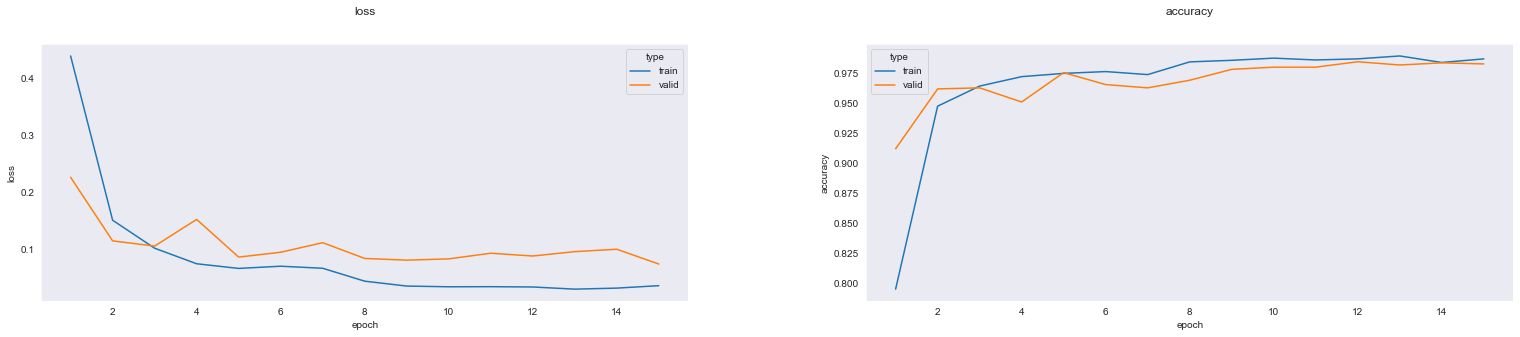

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams["figure.figsize"] = (25, 8)

fig, axes = plt.subplots(1, 2)
fig.tight_layout(pad=15.0)

sns.lineplot(x="epoch", y="loss", hue="type", data=data_eval, ax=axes[0])
sns.lineplot(x="epoch", y="accuracy", hue="type", data=data_eval, ax=axes[1])
axes[0].title.set_text("loss\n\n")
axes[1].title.set_text("accuracy\n\n")

In [45]:
print(
    "Difference between mean accuracy",
    round(
         data_eval[data_eval["type"] == "valid"]["accuracy"].mean()
        - data_eval[data_eval["type"] == "train"]["accuracy"].mean(),
        4,
    ),
    "%",
)
print(
    "Difference between mean loss",
    round(
        data_eval[data_eval["type"] == "valid"]["loss"].mean()
        -data_eval[data_eval["type"] == "train"]["loss"].mean(),
        4,
    ),
)

Difference between mean accuracy 0.0024 %
Difference between mean loss 0.0228


<font color='pink'>**Observation**</font>

* The learning Rate looks good when we see the loss curve
* There is not a big difference between the train- and valid-accuracy's mean so we can assume that the modell is good fitted 
* The mean accuracy looks also good with more than 95 %
* Because of drop out the Modell is likely robust by validation

<font color='cyan'>**Evaluate the modell  on test Data**</font>

In [47]:
loss, acc = evaluate(model, test_iterator)
f"Accuracy on test data is {round(acc*100,2):.2f} %"

'Accuracy on test data is 98.01 %'